In [1]:
import os
import glob
import pickle
import numpy as np
from scipy import io
from mne import viz, stats
from matplotlib import colors, gridspec, pyplot as plt

In [2]:
CAF_DOSE = 200

SIGNIFICANT_P = 0.05
SIGNIFICANT_P_STRONG = 0.01
STRONG_SIGNIFICANCE_COLOR = 'w'

PROJECT_PATH = '..\\data' # path to where the EEG sensor position file is stored
RESULTS_PATH = '..\\results'
FIGURE_PATH = '..\\figures'

STAGES = ['AWSL', 'NREM', 'REM']
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'low gamma']
CHANNELS = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'P3 ', 'P4',
            'O1', 'O2 ', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']

delete_features = ['PSD_alpha', 'PSD_low gamma', 'PermEn', 'SpecPermEn']
delete_classifiers = ['Perceptron']

In [3]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
scores = {}
for path in glob.glob(os.path.join(RESULTS_PATH, f'new_score_single{CAF_DOSE}', f'scores*.pickle')):
    clf = path.split(os.sep)[-1].split('.')[0].split('_')[-1]
    with open(path, 'rb') as file:
        scores[clf] = pickle.load(file)
   
'''
for delete in delete_classifiers:
    del scores[delete]
        
for clf in scores.keys():
    for stage in scores[clf].keys():
        for delete in delete_features:
            del scores[clf][stage][delete]
'''

'\nfor delete in delete_classifiers:\n    del scores[delete]\n        \nfor clf in scores.keys():\n    for stage in scores[clf].keys():\n        for delete in delete_features:\n            del scores[clf][stage][delete]\n'

In [5]:
# correct values with maximum statistics

for clf in scores.keys():
    for stage in scores[clf].keys():
        for feat in scores[clf][stage].keys():
            distributions = []
            for elec in range(len(scores[clf][stage][feat])):
                distributions.append(scores[clf][stage][feat][elec][1])
            distributions = np.array(distributions)
            permutations = np.sort(distributions.max(axis=0))
            
            # compute the accuracy threshold
            threshold = permutations[-int(distributions.shape[1] * SIGNIFICANT_P + 1)]
            threshold_strong = permutations[-int(distributions.shape[1] * SIGNIFICANT_P_STRONG + 1)]
            
            for elec in range(len(scores[clf][stage][feat])):
                scores[clf][stage][feat][elec] = list(scores[clf][stage][feat][elec])
                scores[clf][stage][feat][elec][-1] = threshold
                scores[clf][stage][feat][elec] += [threshold_strong]

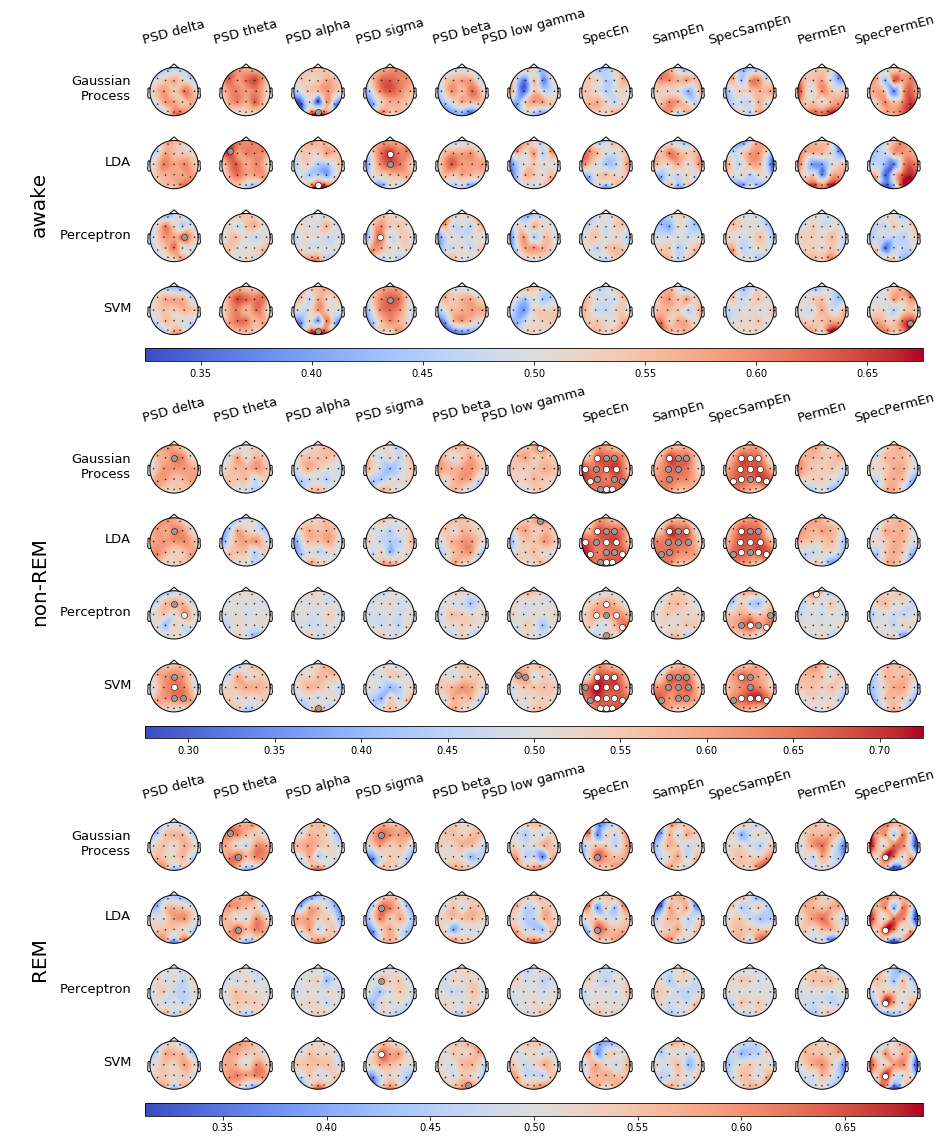

In [6]:
colormap = 'coolwarm'
fontsize_small = 13
fontsize_big = 20

# create gridspec
rows_per_stage = (len(scores) + 3)
gs = gridspec.GridSpec(rows_per_stage * len(STAGES) - 1,
                       len(scores[list(scores.keys())[0]][STAGES[0]]) + 2,
                       width_ratios=[0.5, 1] + [1] * len(scores[list(scores.keys())[0]][STAGES[0]]),
                       height_ratios=(([0.015] + [1] * len(scores) + [0.2, 0.7]) * len(STAGES))[:-1],
                       wspace=0.25,
                       hspace=0.2)
# skip stage annotation plot and empty top left subplot
subplot_counter = 2

#plt.figure(figsize=(10, 12)) # poster version
plt.figure(figsize=(16, 18)) # full version

for stage_index, stage in enumerate(STAGES):
    # add current stage annotations
    plt.subplot(gs[stage_index*rows_per_stage:(stage_index+1)*rows_per_stage-1,0])
    plt.axis('off')
    plt.annotate(stage.replace('AWSL', 'awake').replace('NREM', 'non-REM'),
                 xy=(0, 0.5),
                 ha='left',
                 va='center',
                 rotation=90,
                 fontsize=fontsize_big)

    # add feature name annotations
    for feature in scores[list(scores.keys())[0]][stage].keys():
        plt.subplot(gs[subplot_counter])
        subplot_counter += 1
        
        name = feature.replace('_', ' ').replace('SpecShanEn', 'SpecEn')
        plt.annotate(name,
                     xy=(0.5, 1),
                     ha='center',
                     va='bottom',
                     rotation=15,
                     fontsize=fontsize_small)
        plt.axis('off')
    
    # calculate min and max values for plots and colormaps
    vmin = min([min([min([scores[clf][stage][feature][electrode][0] for electrode in range(20)]) for feature in scores[clf][stage].keys()]) for clf in scores.keys()])
    vmax = max([max([max([scores[clf][stage][feature][electrode][0] for electrode in range(20)]) for feature in scores[clf][stage].keys()]) for clf in scores.keys()])
    diff = max(abs(0.5 - vmin), abs(0.5 - vmax))
    vmin = 0.5 - diff
    vmax = 0.5 + diff
    
    for clf in scores.keys():
        # skip stage text subplot
        subplot_counter += 1
        
        # add classifier name annotations
        for feature in scores[clf][stage].keys():
            if subplot_counter % gs._ncols == 1:
                plt.subplot(gs[subplot_counter])
                subplot_counter += 1
                
                plt.annotate(clf.replace('nP', 'n\nP'), xy=(1, 0.5), ha='right', va='center', fontsize=fontsize_small)
                plt.axis('off')
            
            # get data for plotting
            acc = [score[0] for score in scores[clf][stage][feature]]
            threshold = np.array([score[2] for score in scores[clf][stage][feature]])
            threshold_strong = np.array([score[3] for score in scores[clf][stage][feature]])
            
            plt.subplot(gs[subplot_counter])
            subplot_counter += 1
            
            mask = acc >= threshold
            mask_strong = acc >= threshold_strong
            
            marker_colors = [[0.6, 0.6, 0.6]] * len(mask)
            for i, significant in enumerate(mask_strong):
                if significant:
                    marker_colors[i] = STRONG_SIGNIFICANCE_COLOR
            marker_colors = np.array(marker_colors)[mask]
                
            # plot topomap
            viz.plot_topomap(acc,
                             sensor_pos,
                             mask=mask,
                             vmin=vmin,
                             vmax=vmax,
                             cmap=colormap,
                             mask_params={'markersize': 6, 'markeredgewidth': 0.5, 'markerfacecolor': marker_colors},
                             contours=False,
                             show=False)
    
    # add colorbar
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, cax=plt.subplot(gs[(stage_index+1)*rows_per_stage-2,2:]), orientation='horizontal')
    
    # add space below plot
    if stage_index < len(STAGES) - 1:
        plt.subplot(gs[(stage_index+1)*rows_per_stage-1,2:])
        plt.axis('off')
    subplot_counter += gs._ncols * 2 + 2

plt.savefig(os.path.join(FIGURE_PATH, f'decodingAccuracySingle{CAF_DOSE}', 'decodingAccuracySingle-CORRECTED'),
            bbox_inches='tight',
            transparent=True,
            dpi=200)

plt.show()

AWSL 0.675
NREM 0.725
REM 0.6875


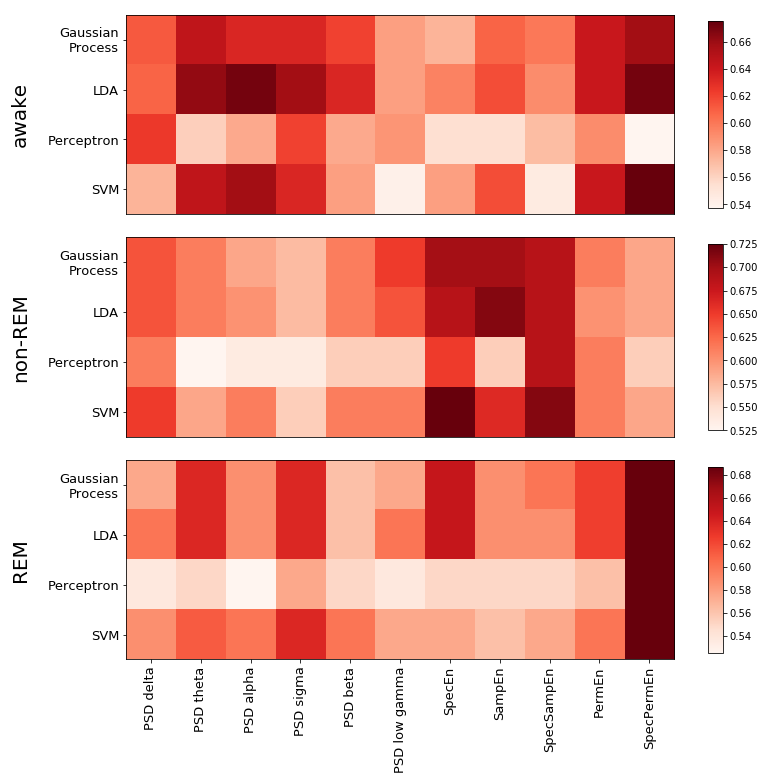

In [7]:
fontsize_small = 13
fontsize_big = 20

feature_names = list(scores[list(scores.keys())[0]][STAGES[0]].keys())
clf_names = list(scores.keys())

# average decoding accuracy scores
avg_acc = dict([(stage, np.empty((len(scores), len(scores[list(scores.keys())[0]][stage])))) for stage in STAGES])
for i, clf in enumerate(scores.keys()):
    for stage in STAGES:
        for j, feature in enumerate(scores[clf][stage].keys()):
            data = [scores[clf][stage][feature][electrode][0] for electrode in range(20)]
            if len(data) > 0:
                avg_acc[stage][i,j] = np.max(data) # show max score across electrodes
                #avg_acc[stage][i,j] = np.mean(data) # show electrode mean
            else:
                avg_acc[stage][i,j] = 0.5

for stage in STAGES:
    print(stage, avg_acc[stage].max())
                
# create gridspec
gs = gridspec.GridSpec(len(STAGES), 2, width_ratios=[0.14, 1], wspace=0, hspace=0.075)
subplot_index = 0
plt.figure(figsize=(14, 12))
extra_artists = []

for stage in STAGES:
    # add current stage annotation
    plt.subplot(gs[subplot_index])
    subplot_index += 1
    extra_artists.append(plt.annotate(stage.replace('AWSL', 'awake').replace('NREM', 'non-REM'),
                                      xy=(0, 0.5),
                                      va='center',
                                      ha='right',
                                      fontsize=fontsize_big,
                                      rotation=90))
    plt.axis('off')
    
    plt.subplot(gs[subplot_index])
    subplot_index += 1
    
    plt.imshow(avg_acc[stage], cmap='Reds')
    
    # add feature name annotations
    if stage == STAGES[-1]:
        names = []
        for name in feature_names:
            name = name.replace('_', ' ').replace('Shan', '')
            names.append(name)
        plt.xticks(np.arange(len(feature_names)), names, rotation=90, fontsize=fontsize_small)
    else:
        plt.xticks([])
    
    # add classifier name annotations
    plt.yticks(np.arange(len(clf_names)), [name.replace('nP', 'n\nP') for name in clf_names], fontsize=fontsize_small)
    plt.colorbar(shrink=0.9, aspect=13)

plt.savefig(os.path.join(FIGURE_PATH, f'decodingAccuracySingle{CAF_DOSE}', f'decodingAccuracySingle-matrix'),
            bbox_inches='tight',
            transparent=True,
            bbox_extra_artists=extra_artists,
            dpi=200)
plt.show()